# Usage Demo : 


In [1]:
import midi
import glob
import numpy as np
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
from mgeval import core, utils
from sklearn.model_selection import LeaveOneOut

## Absolute measurement: statistic analysis


Assign dataset path

In [2]:
set1 = glob.glob('data/output/*')
print(set1)


['data/output/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--4.midi', 'data/output/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--5.midi', 'data/output/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--1.midi', 'data/output/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_04_R2_2013_wav--3.midi', 'data/output/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--4.midi', 'data/output/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--3.midi', 'data/output/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_06_R1_2013_wav--4.midi', 'data/output/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--2.midi', 'data/output/ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--1.midi', 'data/output/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_18_R2_2013_wav--3.midi', 'data/output/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--1.midi', 'data/output/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--3.midi', 'data/output/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_03_R1_2013_wav--1.midi', 'data/outpu

construct empty dictionary to fill in measurement across samples

In [3]:
#num_samples = 100
num_samples = 20

In [4]:
set1_eval = {'total_used_pitch':np.zeros((num_samples,1))}
metrics_list = set1_eval.keys()
for i in range(0, num_samples):
    feature = core.extract_feature(set1[i])
    set1_eval[metrics_list[0]][i] = getattr(core.metrics(), metrics_list[0])(feature)

repeat for second dataset

In [5]:
# set2 = glob.glob('../data/set2/*.mid')
set2 = glob.glob('data/baseline/*')
set2_eval = {'total_used_pitch':np.zeros((num_samples,1))}
for i in range(0, num_samples):
    feature = core.extract_feature(set2[i])
    set2_eval[metrics_list[0]][i] = getattr(core.metrics(), metrics_list[0])(feature)

statistic analysis: absolute measurement

In [6]:
for i in range(0, len(metrics_list)):
    print metrics_list[i] + ':'
    print '------------------------'
    print ' demo_set'
    print '  mean: ', np.mean(set1_eval[metrics_list[i]], axis=0)
    print '  std: ', np.std(set1_eval[metrics_list[i]], axis=0)

    print '------------------------'
    print ' demo_set'
    print '  mean: ', np.mean(set2_eval[metrics_list[i]], axis=0)
    print '  std: ', np.std(set2_eval[metrics_list[i]], axis=0)


total_used_pitch:
------------------------
 demo_set
  mean:  [62.35]
  std:  [11.84176929]
------------------------
 demo_set
  mean:  [62.35]
  std:  [11.84176929]


## Relative measurement: generalizes the result among features with various dimensions


the features are sum- marized to 
- the intra-set distances
- the difference of intra-set and inter-set distances.

exhaustive cross-validation for intra-set distances measurement

In [7]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
set1_intra = np.zeros((num_samples, len(metrics_list), num_samples))
set2_intra = np.zeros((num_samples, len(metrics_list), num_samples))
for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        set1_intra[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set1_eval[metrics_list[i]][train_index])
        set2_intra[test_index[0]][i] = utils.c_dist(set2_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]][train_index])


exhaustive cross-validation for inter-set distances measurement

In [8]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        sets_inter[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]])

visualization of intra-set and inter-set distances

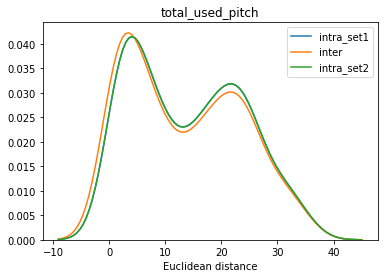

In [9]:
plot_set1_intra = np.transpose(set1_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_set2_intra = np.transpose(set2_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter,(1, 0, 2)).reshape(len(metrics_list), -1)
for i in range(0,len(metrics_list)):
    sns.kdeplot(plot_set1_intra[i], label='intra_set1')
    sns.kdeplot(plot_sets_inter[i], label='inter')
    sns.kdeplot(plot_set2_intra[i], label='intra_set2')

    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.show()

the difference of intra-set and inter-set distances.

In [10]:
for i in range(0, len(metrics_list)):
    print metrics_list[i] + ':'
    print '------------------------'
    print ' demo_set1'
    print '  Kullback–Leibler divergence:',utils.kl_dist(plot_set1_intra[i], plot_sets_inter[i])
    print '  Overlap area:', utils.overlap_area(plot_set1_intra[i], plot_sets_inter[i])
    
    print ' demo_set2'
    print '  Kullback–Leibler divergence:',utils.kl_dist(plot_set2_intra[i], plot_sets_inter[i])
    print '  Overlap area:', utils.overlap_area(plot_set2_intra[i], plot_sets_inter[i])
    

total_used_pitch:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.0013766431838582623
  Overlap area: 0.893103183927
 demo_set2
  Kullback–Leibler divergence: 0.0013766431838582623
  Overlap area: 0.893103183927
